## Vignette: scRNA-Seq across-sample integration, first pass, and downstream analysis
*Recommended steps prior to this analysis are ambient RNA decontamination (SoupX or Cellbender) followed by doublet identification (Scrublet)*
1. Read in SoupX-cleaned, doublet-removed UMI count matrices
2. Plot QC metrics (nFeature, nCount, percent.mt) for each sample
3. Perform standard Seurat CCA across-sample integration
4. Quantify retrieval of cell type markers from scRNA-Seq in corresponding snRNA-Seq runs

In [41]:
library(Seurat)
library(hdf5r)
library(dplyr)
library(uwot)
library(ggplot2)
library(useful)
library(plyr)
library(ggpubr)
library(VISION)
library(RColorBrewer)
library(fgsea)

## Read in cleaned UMI matrices, merge, and create metadata table
These are samples from three patients, P915, P913, and P906, in the metastatic clear-cell RCC cohort (unsorted tumor and immune cells from immune checkpoint blockade treated tumors). P915 exhibited a partial response to therapy, while P913 and P906 exhibited either stable disease or progressive disease.

In [42]:
p915 <- readRDS("/broad/VanAllenLab_CA/xchip/cga_home/kevinbi/RCC_GENCODE30Liftover/March2020_RCC_Raw/p915/P915_SoupX_Scrublet_Cleaned_RawMatrix.RDS")
p913 <- readRDS("/broad/VanAllenLab_CA/xchip/cga_home/kevinbi/RCC_GENCODE30Liftover/March2020_RCC_Raw/p913/P913_SoupX_Scrublet_Cleaned_RawMatrix.RDS")
p906 <- readRDS("/broad/VanAllenLab_CA/xchip/cga_home/kevinbi/RCC_GENCODE30Liftover/March2020_RCC_Raw/p906/P906_SoupX_Scrublet_Cleaned_RawMatrix.RDS")

In [43]:
colnames(p915) <- paste(colnames(p915),"p915", sep = ".")
colnames(p913) <- paste(colnames(p913),"p913", sep = ".")
colnames(p906) <- paste(colnames(p906),"p906", sep = ".")

In [44]:
p915 <- data.frame(p915)
p913 <- data.frame(p913)
p906 <- data.frame(p906)

p915$gene <- row.names(p915)
p913$gene <- row.names(p913)
p906$gene <- row.names(p906)

In [45]:
merged <- join_all(list(p915,p913,p906), by = "gene")
drops <- c("gene")
merged_final <- merged[ , !(names(merged) %in% drops)]
row.names(merged_final) <- merged$gene

In [46]:
dim(merged_final)

[1] 60627 15760

In [47]:
saveRDS(merged_final, file = "/broad/VanAllenLab_CA/xchip/cga_home/kevinbi/RCC_GENCODE30Liftover/March2020_RCC_Raw/2samples_RCC_Documentation_RawMergedCounts.RDS")

In [48]:
names <- colnames(merged_final)
x <- strsplit(names,"[.]")
patient <- sapply(x, "[", 2)
corner(patient)
meta <- data.frame(patient)
row.names(meta) <- names
corner(meta)
dim(meta)

[1] "p915" "p915" "p915" "p915" "p915"

,patient
,<fct>
AAACCTGAGCCAGTTT.p915,p915
AAACCTGCAAGGTTCT.p915,p915
AAACCTGCACTATCTT.p915,p915
AAACCTGCAGCTGGCT.p915,p915
AAACCTGCATCGTCGG.p915,p915


[1] 15760     1

In [49]:
meta <- mutate(meta, ICB_Response = ifelse(patient %in% c("p915"), "PR", "SD/PD"))
row.names(meta) <- names
head(meta)

,patient,ICB_Response
,<fct>,<chr>
AAACCTGAGCCAGTTT.p915,p915,PR
AAACCTGCAAGGTTCT.p915,p915,PR
AAACCTGCACTATCTT.p915,p915,PR
AAACCTGCAGCTGGCT.p915,p915,PR
AAACCTGCATCGTCGG.p915,p915,PR
AAACCTGCATGTAAGA.p915,p915,PR


In [50]:
biopsy <- as.character(meta$patient)
biopsy <- replace(biopsy, biopsy == "p915", "kidney")
biopsy <- replace(biopsy, biopsy == "p913", "lung")
biopsy <- replace(biopsy, biopsy == "p906", "lymphnode")
meta$biopsy <- biopsy
head(meta)

,patient,ICB_Response,biopsy
,<fct>,<chr>,<chr>
AAACCTGAGCCAGTTT.p915,p915,PR,kidney
AAACCTGCAAGGTTCT.p915,p915,PR,kidney
AAACCTGCACTATCTT.p915,p915,PR,kidney
AAACCTGCAGCTGGCT.p915,p915,PR,kidney
AAACCTGCATCGTCGG.p915,p915,PR,kidney
AAACCTGCATGTAAGA.p915,p915,PR,kidney


In [51]:
corner(subset(meta, patient == "p913"))

,patient,ICB_Response,biopsy
,<fct>,<chr>,<chr>
AAACCTGAGATCTGAA.p913,p913,SD/PD,lung
AAACCTGAGATGTCGG.p913,p913,SD/PD,lung
AAACCTGAGGAGCGAG.p913,p913,SD/PD,lung
AAACCTGAGTTAGGTA.p913,p913,SD/PD,lung
AAACCTGCAGCCAATT.p913,p913,SD/PD,lung


## Create Seurat object, filter cells and genes

In [52]:
rcc_seur <- CreateSeuratObject(merged_final, meta.data = meta, min.cells = 3, min.features = 200)
rcc_seur[["percent.mt"]] <- PercentageFeatureSet(rcc_seur, pattern = "^MT-")
Idents(rcc_seur) <- "patient"

Warning message:
"Feature names cannot have underscores ('_'), replacing with dashes ('-')"

## Extract QC metadata and plot

,orig.ident,nCount_RNA,nFeature_RNA,patient,ICB_Response,biopsy,percent.mt,log10_nFeature_RNA,log10_nCount_RNA
,<fct>,<dbl>,<int>,<fct>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
AAACCTGAGCCAGTTT.p915,SeuratProject,1600.901,788,p915,PR,kidney,1.9513471,2.896526,3.204364
AAACCTGCAAGGTTCT.p915,SeuratProject,1616.683,818,p915,PR,kidney,0.7863654,2.912753,3.208625
AAACCTGCACTATCTT.p915,SeuratProject,11244.387,2656,p915,PR,kidney,3.0104071,3.424228,4.050936
AAACCTGCAGCTGGCT.p915,SeuratProject,1940.253,846,p915,PR,kidney,2.3856765,2.927370,3.287858
AAACCTGCATCGTCGG.p915,SeuratProject,1755.737,299,p915,PR,kidney,84.0361623,2.475671,3.244459
AAACCTGCATGTAAGA.p915,SeuratProject,1753.756,779,p915,PR,kidney,0.8735420,2.891537,3.243969


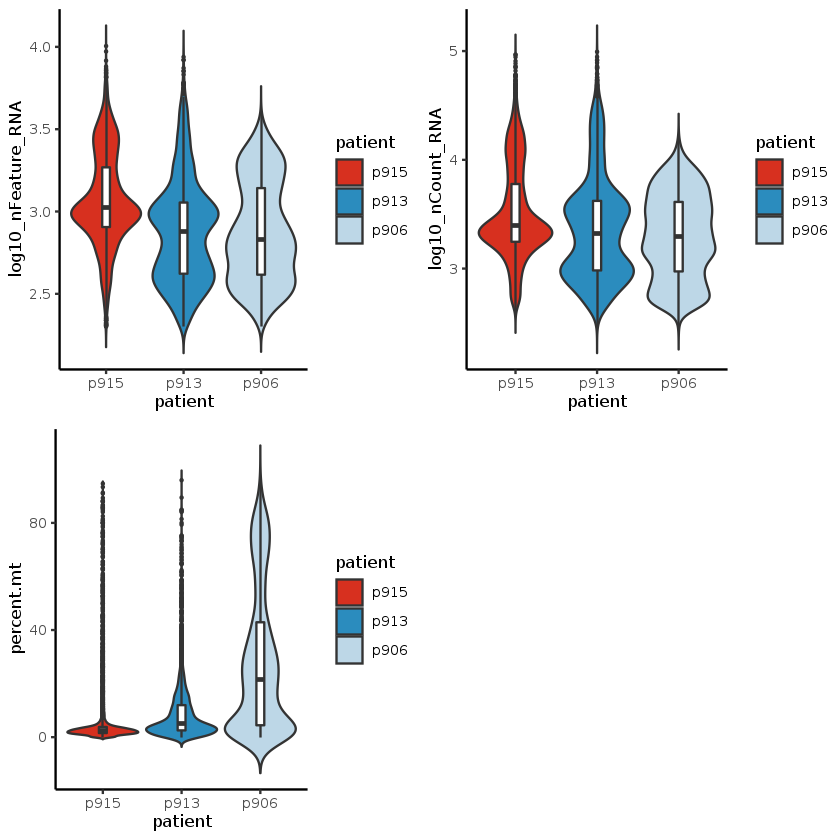

In [53]:
meta <- rcc_seur@meta.data
meta$log10_nFeature_RNA <- log(meta$nFeature_RNA, 10)
meta$log10_nCount_RNA <- log(meta$nCount_RNA, 10)
head(meta)

meta$patient <- factor(meta$patient, levels = c("p915",'p913','p906'))

nfeat <- ggplot(meta, aes(x=patient, y=log10_nFeature_RNA, fill=patient)) + 
  geom_violin(trim=FALSE, scale = 'width')+
  geom_boxplot(width=0.1, fill="white", outlier.size = 0.2) + theme_classic() + theme(text = element_text(size = 10)) + scale_fill_manual(values = c("#d7301f","#2b8cbe","#bdd7e7"))

ncount <- ggplot(meta, aes(x=patient, y=log10_nCount_RNA, fill=patient)) + 
  geom_violin(trim=FALSE, scale = 'width')+
  geom_boxplot(width=0.1, fill="white", outlier.size = 0.2) + theme_classic() + theme(text = element_text(size = 10)) + scale_fill_manual(values = c("#d7301f","#2b8cbe","#bdd7e7"))

pct.mt <- ggplot(meta, aes(x=patient, y=percent.mt, fill=patient)) + 
  geom_violin(trim=FALSE, scale = 'width')+
  geom_boxplot(width=0.1, fill="white", outlier.size = 0.2) + theme_classic() + theme(text = element_text(size = 10)) + scale_fill_manual(values = c("#d7301f","#2b8cbe","#bdd7e7"))

ggarrange(nfeat, ncount, pct.mt, nrow = 2, ncol = 2)

## Perform additional cell filtering step, retain cells with percent.mt < 25%

In [54]:
rcc_seur <- subset(rcc_seur, subset = nFeature_RNA > 200 & percent.mt < 25)

## Perform standard CCA integration workflow with default parameters

In [55]:
rcc_seur <- CreateSeuratObject(merged_final, meta.data = meta, min.cells = 3, min.features = 200)
rcc_seur[["percent.mt"]] <- PercentageFeatureSet(rcc_seur, pattern = "^MT-")
rcc_seur <- subset(rcc_seur, subset = nFeature_RNA > 200 & percent.mt < 25)
Idents(rcc_seur) <- "patient"

rcc.list <- SplitObject(rcc_seur, split.by = "patient")
rcc.list <- rcc.list[c("p915","p913","p906")]
for (i in 1:length(rcc.list)) {
    rcc.list[[i]] <- NormalizeData(rcc.list[[i]], verbose = FALSE)
    rcc.list[[i]] <- FindVariableFeatures(rcc.list[[i]], selection.method = "vst", verbose = FALSE)
}
reference.list <- rcc.list[c("p915","p913","p906")]
rcc.anchors <- FindIntegrationAnchors(object.list = reference.list, dims = 1:50)
rcc.integrated <- IntegrateData(anchorset = rcc.anchors, dims = 1:50)
library(ggplot2)
library(cowplot)
# switch to integrated assay. The variable features of this assay are automatically
# set during IntegrateData
DefaultAssay(rcc.integrated) <- "integrated"

Warning message:
"Feature names cannot have underscores ('_'), replacing with dashes ('-')"Computing 2000 integration features
Scaling features for provided objects
Finding all pairwise anchors
Running CCA
Merging objects
Finding neighborhoods
Finding anchors
	Found 9934 anchors
Filtering anchors
	Retained 3850 anchors
Extracting within-dataset neighbors
Running CCA
Merging objects
Finding neighborhoods
Finding anchors
	Found 6753 anchors
Filtering anchors
	Retained 3659 anchors
Extracting within-dataset neighbors
Running CCA
Merging objects
Finding neighborhoods
Finding anchors
	Found 6042 anchors
Filtering anchors
	Retained 3120 anchors
Extracting within-dataset neighbors
Merging dataset 3 into 1
Extracting anchors for merged samples
Finding integration vectors
Finding integration vector weights
Integrating data
Merging dataset 2 into 1 3
Extracting anchors for merged samples
Finding integration vectors
Finding integration vector weights
Integrating data
Warning message:
"Adding a co

## Scale data, perform PCA, then UMAP on first fifty principal components

Warning message:
"The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session"08:31:24 UMAP embedding parameters a = 0.9922 b = 1.112
08:31:24 Read 12673 rows and found 50 numeric columns
08:31:24 Using Annoy for neighbor search, n_neighbors = 30
08:31:24 Building Annoy index with metric = cosine, n_trees = 50
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
08:31:30 Writing NN index file to temp file /tmp/21672004.1.interactive/Rtmpr0P3mk/file7b214f0436d4
08:31:30 Searching Annoy index using 1 thread, search_k = 3000
08:31:35 Annoy recall = 100%
08:31:35 Commencing smooth kNN distance calibration using 1 thread
08:31:37 Initializing from normalized Laplacian + noise
08:31:3

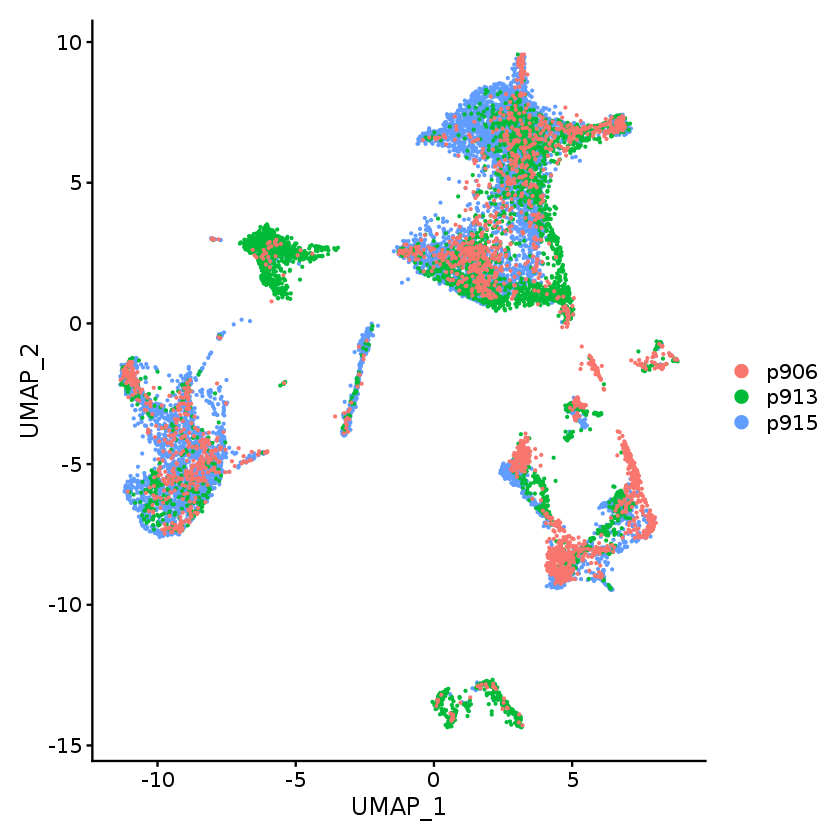

In [56]:
rcc.integrated <- ScaleData(rcc.integrated, verbose = FALSE)
rcc.integrated <- RunPCA(rcc.integrated, npcs = 50, verbose = FALSE)
rcc.integrated <- RunUMAP(rcc.integrated, reduction = "pca", dims = 1:50)
DimPlot(rcc.integrated)

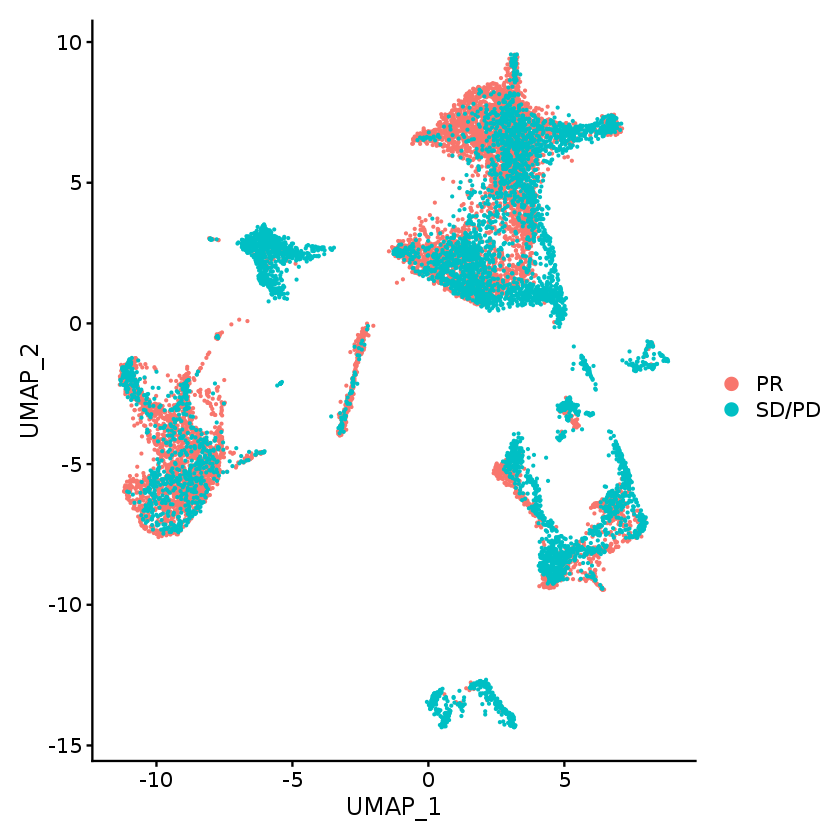

In [57]:
DimPlot(rcc.integrated, group.by = 'ICB_Response')

## Perform Louvain clustering on first fifty principal components, visualize clusters
Note that clustering resolution can be manually tuned to better correspond with spatially resolved groupings in UMAP space.

Computing nearest neighbor graph
Computing SNN


Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 12673
Number of edges: 839127

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9393
Number of communities: 14
Elapsed time: 3 seconds


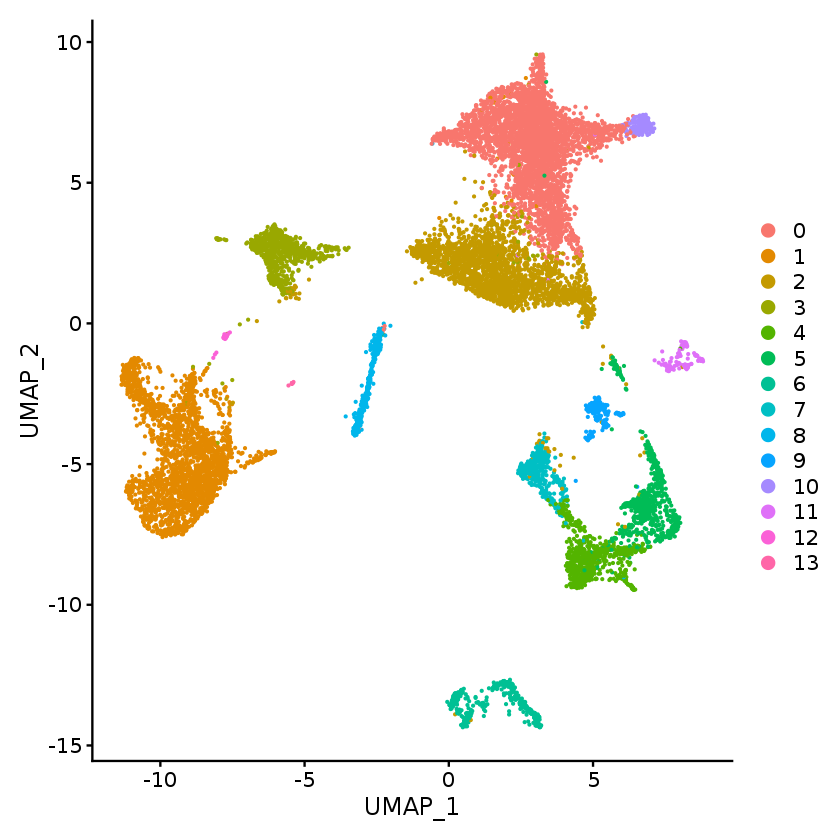

In [58]:
rcc.integrated <- FindNeighbors(rcc.integrated, dims = 1:50)
rcc.integrated <- FindClusters(rcc.integrated, resolution = 0.2)
DimPlot(rcc.integrated)

In [59]:
saveRDS(rcc.integrated, file = "/broad/VanAllenLab_CA/xchip/cga_home/kevinbi/RCC_GENCODE30Liftover/March2020_RCC_Raw/RCC_Documentation_IntegratedSeurat.RDS")

## Differential expression analysis and cell type annotation
We now perform Wilcoxon differential expression between cells of each cluster and cells of all other clusters to identify cluster-specific markers for cell type annotation. Note that for all differential expression analysis we specify the paramater assay = "RNA". This ensures that our comparisons are performed on true UMI counts, and not integration-transformed counts, which do not preserve true biological variability inherent to the cohort design. Per the recommendation of the Seurat developers, integration-transformed counts should be used only for visualization, ie PCA, UMAP, and clustering. 

In [60]:
rcc.markers <- FindAllMarkers(rcc.integrated, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25, assay = "RNA")
rcc.markers %>% group_by(cluster) %>% top_n(n = 3, wt = avg_logFC)

Calculating cluster 0
Calculating cluster 1
Calculating cluster 2
Calculating cluster 3
Calculating cluster 4
Calculating cluster 5
Calculating cluster 6
Calculating cluster 7
Calculating cluster 8
Calculating cluster 9
Calculating cluster 10
Calculating cluster 11
Calculating cluster 12
Calculating cluster 13


p_val,avg_logFC,pct.1,pct.2,p_val_adj,cluster,gene
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
0.000000e+00,2.6694370,0.966,0.209,0.000000e+00,0,CCL5
0.000000e+00,2.6149106,0.889,0.129,0.000000e+00,0,NKG7
0.000000e+00,2.2958637,0.819,0.113,0.000000e+00,0,CCL4
0.000000e+00,4.0194360,0.732,0.141,0.000000e+00,1,APOE
0.000000e+00,3.9706477,0.816,0.068,0.000000e+00,1,C1QB
0.000000e+00,3.8615449,0.835,0.070,0.000000e+00,1,C1QA
0.000000e+00,1.6276772,0.437,0.046,0.000000e+00,2,IL7R
1.121928e-297,1.2080658,0.583,0.232,2.805941e-293,2,LTB
3.895859e-178,0.9514934,0.753,0.642,9.743543e-174,2,JUNB


Plot heatmap of top genes for each cluster, downsampling each cluster to 100 cells so that smaller clusters are not obscured.

Warning message in DoHeatmap(subset(rcc.integrated, downsample = 100), features = top5$gene):
"The following features were omitted as they were not found in the scale.data slot for the integrated assay: SNX3, WSB1, PABPC1, JUNB, SPOCK2"

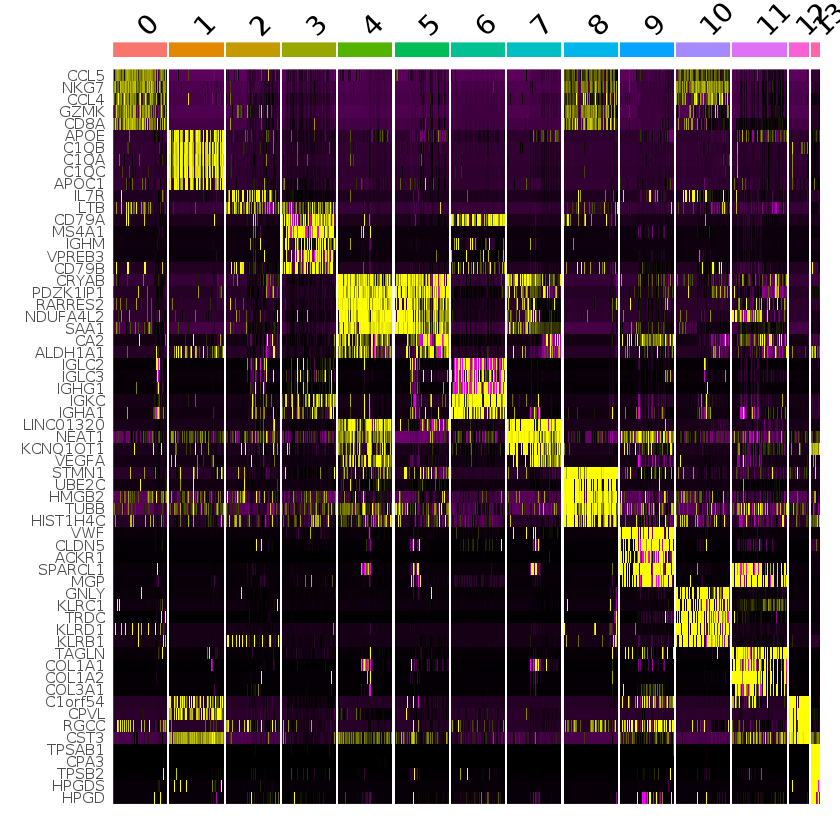

In [61]:
top5 <- rcc.markers %>% group_by(cluster) %>% top_n(n = 5, wt = avg_logFC)
DoHeatmap(subset(rcc.integrated, downsample = 100), features = top5$gene) + NoLegend()

FeaturePlot to visualize canonical cell type specific genes and DE-identified cluster markers. Note that again, to visualize true expression as opposed to integration-transformed counts, we set DefaultAssay to "RNA" before plotting, then reset DefaultAssay to "integrated" following plotting. 

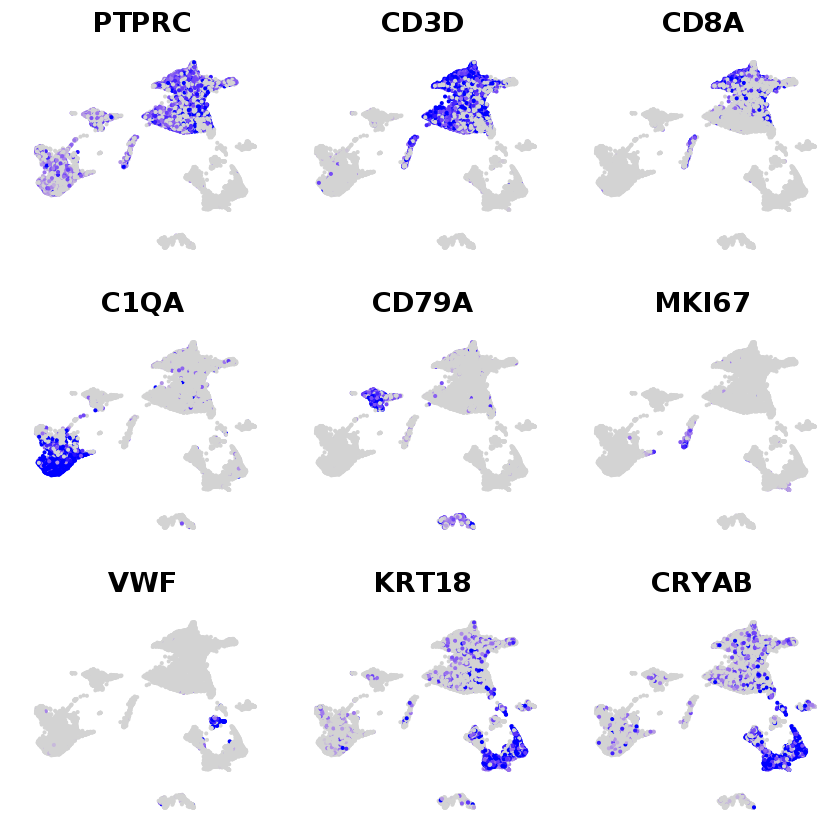

In [62]:
DefaultAssay(rcc.integrated) <- "RNA"
p <- FeaturePlot(rcc.integrated, c("PTPRC","CD3D","CD8A","C1QA","CD79A","MKI67","VWF","KRT18","CRYAB"), pt.size = 0.1, min.cutoff = 0, max.cutoff = 3, combine = F, order = F)

for(i in 1:length(p)) {
  p[[i]] <- p[[i]] + NoLegend() + NoAxes()
}

cowplot::plot_grid(plotlist = p)
DefaultAssay(rcc.integrated) <- "integrated"

Based on prior knowledge of markers for major immune and stromal cell types, as well as canonical renal cancer markers,  we can assign a rough cell type to each unsupervised cluster and update the working identity in the Seurat object. Below, we again show the top differentially expressed genes for each cluster. Often times, it is necessary to more deeply interrogate the DE results to firmly establish cell type identity. For this purpose we export the full results as a text file.

In [63]:
rcc.markers %>% group_by(cluster) %>% top_n(n = 2, wt = avg_logFC)

p_val,avg_logFC,pct.1,pct.2,p_val_adj,cluster,gene
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
0.000000e+00,2.669437,0.966,0.209,0.000000e+00,0,CCL5
0.000000e+00,2.614911,0.889,0.129,0.000000e+00,0,NKG7
0.000000e+00,4.019436,0.732,0.141,0.000000e+00,1,APOE
0.000000e+00,3.970648,0.816,0.068,0.000000e+00,1,C1QB
0.000000e+00,1.627677,0.437,0.046,0.000000e+00,2,IL7R
1.121928e-297,1.208066,0.583,0.232,2.805941e-293,2,LTB
0.000000e+00,2.262725,0.866,0.068,0.000000e+00,3,CD79A
0.000000e+00,2.219074,0.787,0.011,0.000000e+00,3,MS4A1
3.121457e-219,2.101095,0.486,0.114,7.806764e-215,4,NDUFA4L2


In [64]:
subset(rcc.markers, cluster == 0 & p_val_adj < 0.01)[1:20,]

,p_val,avg_logFC,pct.1,pct.2,p_val_adj,cluster,gene
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
CCL5,0,2.669437,0.966,0.209,0,0,CCL5
NKG7,0,2.614911,0.889,0.129,0,0,NKG7
CCL4,0,2.295864,0.819,0.113,0,0,CCL4
GZMK,0,2.213176,0.842,0.105,0,0,GZMK
CD8A,0,2.063413,0.752,0.060,0,0,CD8A
GZMH,0,2.043752,0.616,0.054,0,0,GZMH
GZMA,0,1.932406,0.887,0.130,0,0,GZMA
CST7,0,1.709023,0.754,0.142,0,0,CST7
CD8B,0,1.642744,0.582,0.050,0,0,CD8B


In [65]:
write.table(rcc.markers, file = "/broad/VanAllenLab_CA/xchip/cga_home/kevinbi/RCC_GENCODE30Liftover/March2020_RCC_Raw/RCC_Full_DE_Wilcoxon.txt", sep = '\t', quote = F, col.names = NA)

In [66]:
#CD8 - CD8A, CCL5, CCL4, TRBC2 (0)
#TAM - APOE, C1QB, C1QA (1)
#T_Helper - IL7R, LTB, KLRB1 (2)
#B_cell - MS4A1, CD79A, IGHM (3)
#Putative_Tumor - CRYAB, CLU, KRT8, KRT19,NEAT1, VEGFA (4,5,7)
#Plasma_cell - IGLC2, IGHG1, IGKC, JCHAIN (6)
#Cycling - STMN1, MKI67, TOP2A (8)
#Endothelial - VWF, CLDN5, ACKR1 (9)
#GammaDelta - TRDC, GNLY, CD160, KLRD1, KLRC1, KLRF1 (10)
#Fibroblast - COL1A1, COL1A2, TAGLN (11)
#CLEC9A+ DC - CLEC9A, XCR1, FLT3, IDO1 (12)
#Mast_cell - TPSAB1, TPSB2, CPA3 (13)

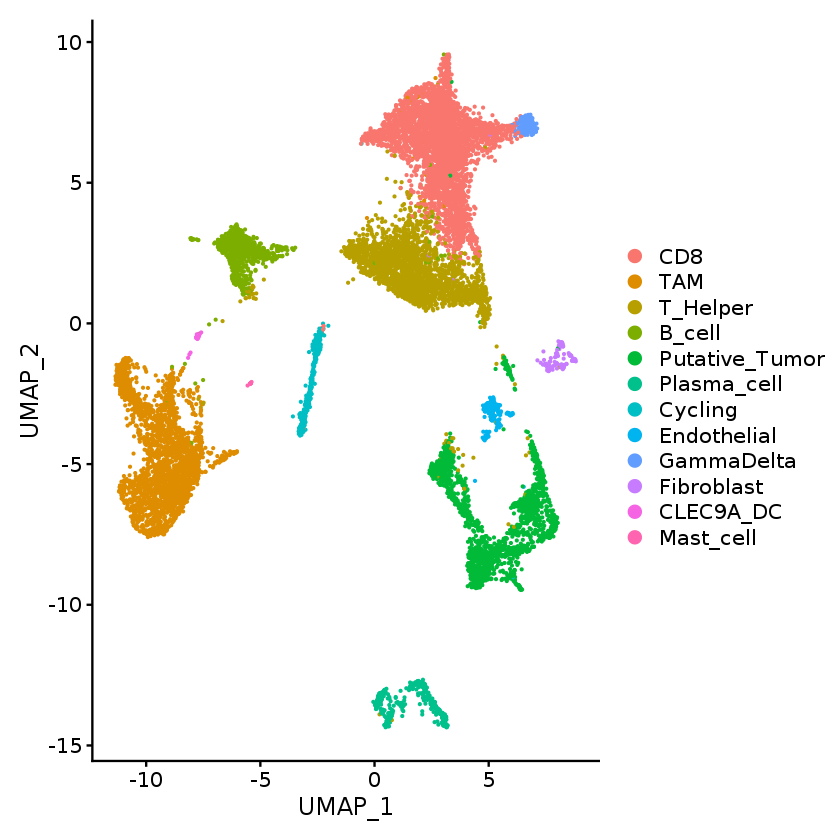

In [67]:
rcc.integrated <- RenameIdents(rcc.integrated, '0' = 'CD8','1'='TAM','2'='T_Helper','3' = 'B_cell','4' = 'Putative_Tumor','5'='Putative_Tumor','6'='Plasma_cell','7'='Putative_Tumor','8'='Cycling','9' = "Endothelial",'10' = 'GammaDelta','11'='Fibroblast','12'='CLEC9A_DC','13'='Mast_cell')
DimPlot(rcc.integrated)

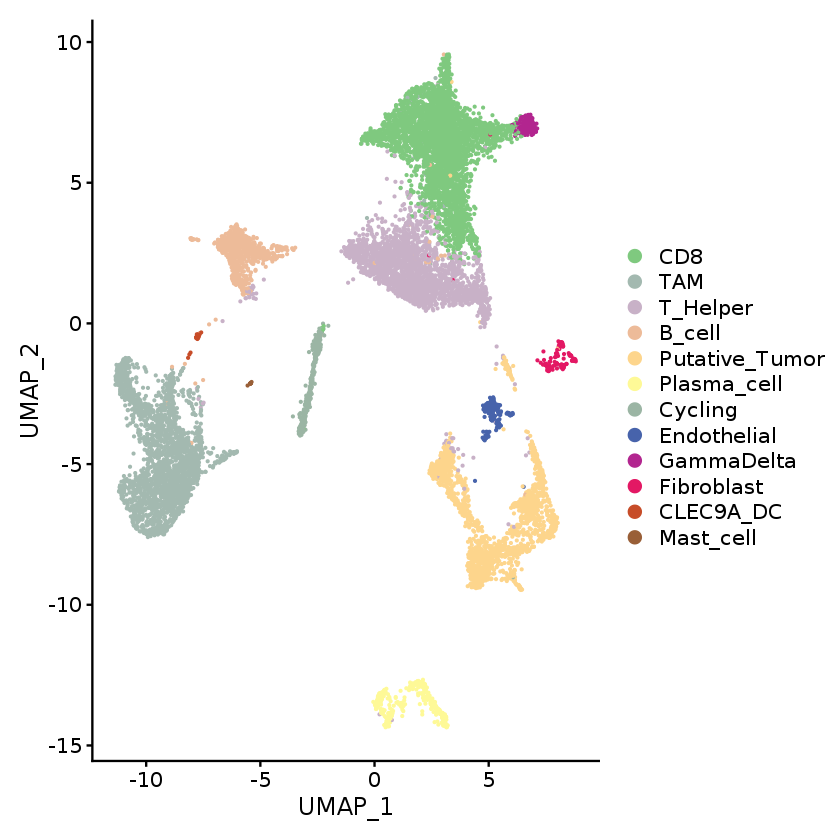

In [68]:
nb.cols <- 13
mycolors <- colorRampPalette(brewer.pal(8, "Accent"))(nb.cols)
DimPlot(rcc.integrated, cols = mycolors)

## Calculate and plot cell type proportions across patients or treatment conditions

Var1,Var2,Freq
<fct>,<fct>,<dbl>
CD8,p906,0.1707942
TAM,p906,0.1746371
T_Helper,p906,0.1857387
B_cell,p906,0.0175064
Putative_Tumor,p906,0.3603757


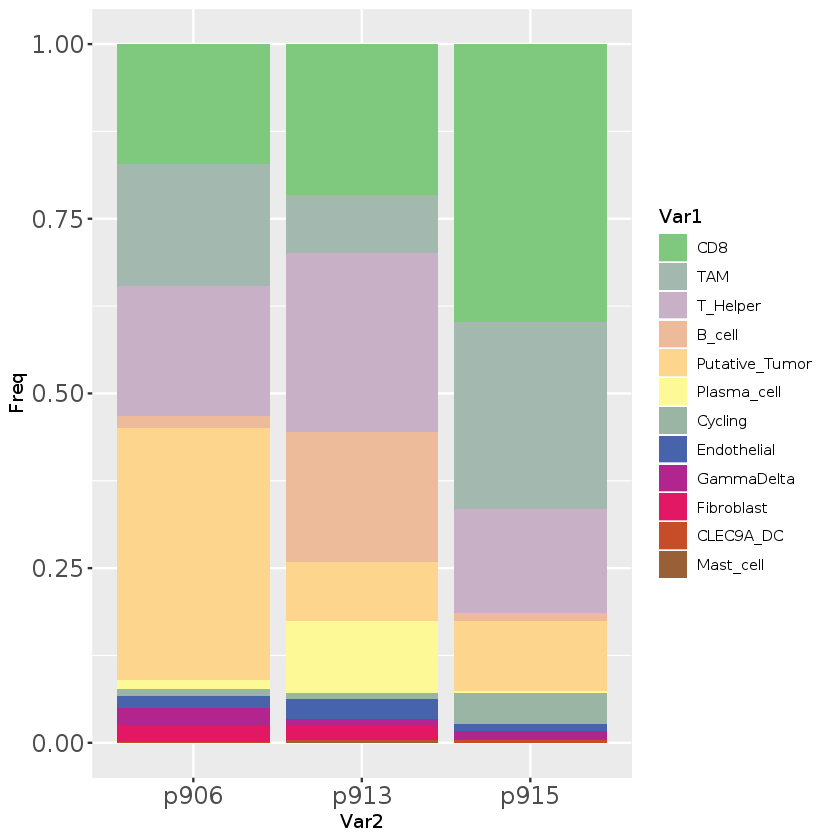

In [69]:
props <- prop.table(table(Idents(rcc.integrated),rcc.integrated$patient), margin = 2)
props <- data.frame(props)
corner(props)

ggplot() + geom_bar(aes(y = Freq, x = Var2, fill = Var1), data = props, stat="identity") +theme(axis.text.x = element_text(size=14),
          axis.text.y = element_text(size=14)) + scale_fill_manual(values = mycolors)

Var1,Var2,Freq
<fct>,<fct>,<dbl>
CD8,PR,0.39654388
TAM,PR,0.26860694
T_Helper,PR,0.14840079
B_cell,PR,0.01106564
Putative_Tumor,PR,0.10019706


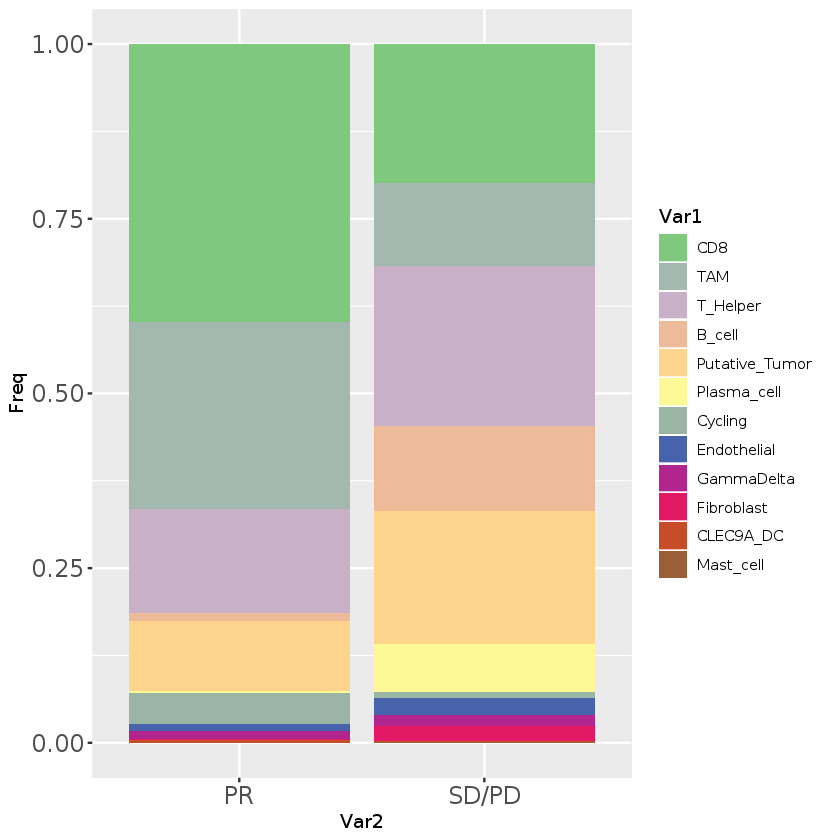

In [70]:
props <- prop.table(table(Idents(rcc.integrated),rcc.integrated$ICB_Response), margin = 2)
props <- data.frame(props)
corner(props)

ggplot() + geom_bar(aes(y = Freq, x = Var2, fill = Var1), data = props, stat="identity") +theme(axis.text.x = element_text(size=14),
          axis.text.y = element_text(size=14)) + scale_fill_manual(values = mycolors)

To more comprehensively describe within-cell-type heterogeneity, we can subset the dataset to a single cell type and re-perform scaling, dimension reduction, clustering, and visualization. Given that the three patients in this vignette were all treated with checkpoint inhibitors (either aPD-1 monotherapy or aPD-1/a-CTLA4 combination therapy), the CD8 T-cell compartment is of great interest. We may wish to characterize heterogeneity in CD8 function, or differential characteristics of CD8s in responders (p915) versus non-responders (p913, p906).

A dotplot is a useful visualization for understanding which clusters are roughly positive/negative for key transcriptional markers. Below, we can see that both cluster 0 (CD8s) and cluster 8 (cycling cells) strongly co-express CD8A, CD3D, and TRBC2. Thus, the cycling cluster is constituted of a large proportion of CD8s, and both clusters should be regarded in a subsetted analysis of CD8 T cells. 

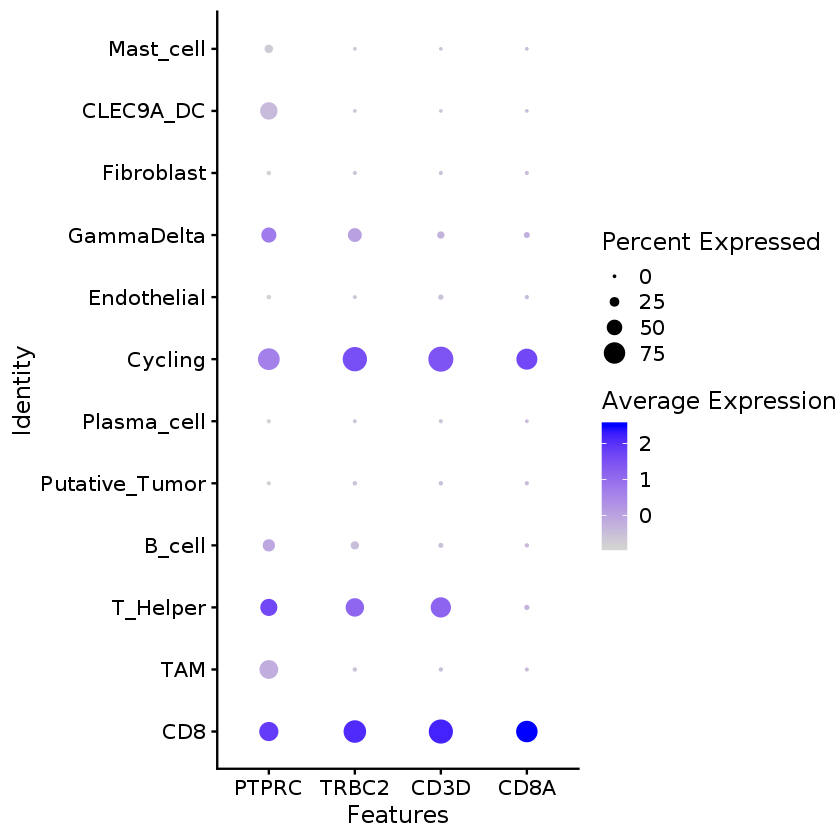

In [71]:
DotPlot(rcc.integrated, c("CD8A","CD3D","TRBC2","PTPRC"),assay = "RNA")

## Subset Seurat object to a specific cell type, then re-cluster and re-visualize

Here we subset to CD8s, re-scale, re-identify variable features, then perform dimension reduction and clustering only on this subset of cells. 

Warning message in FindVariableFeatures.Assay(object = assay.data, selection.method = selection.method, :
"selection.method set to 'vst' but count slot is empty; will use data slot instead"Warning message in eval(predvars, data, env):
"NaNs produced"Warning message in hvf.info$variance.expected[not.const] <- 10^fit$fitted:
"number of items to replace is not a multiple of replacement length"Centering and scaling data matrix
PC_ 1 
Positive:  CCL5, STEAP3, AC093895.1, AF106564.1, AL121768.2, EDN2, FAM107A, SAA1, FTL, LYVE1 
	   CLEC5A, CABP1, RETN, CCL4, NKG7, MYH14, DLL4, CRYAB, MSX1, AC092118.1 
	   GZMH, P2RY13, SLC18A2, C4BPA, IL33, FCER1A, KCNJ8, SLC7A2, NKX2-1, SPP1 
Negative:  UBE2C, BIRC5, AURKB, TOP2A, MKI67, CCNB2, GTSE1, STMN1, CDC20, CDK1 
	   MXD3, CKS1B, CDKN3, ZWINT, CENPA, PCLAF, CENPF, RRM2, PLK1, KIF2C 
	   KIFC1, CENPW, HIST1H4C, CCNA2, TUBB4B, TUBA1B, SPC25, CDCA3, TYMS, CDCA8 
PC_ 2 
Positive:  LINC02015, FGF18, SERPINE1, LINC00472, HTRA3, CCNA1, TMEM233, HCAR2, ITGB

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 4172
Number of edges: 176871

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9271
Number of communities: 3
Elapsed time: 0 seconds


08:37:47 UMAP embedding parameters a = 0.9922 b = 1.112
08:37:47 Read 4172 rows and found 30 numeric columns
08:37:47 Using Annoy for neighbor search, n_neighbors = 30
08:37:47 Building Annoy index with metric = cosine, n_trees = 50
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
08:37:49 Writing NN index file to temp file /tmp/21672004.1.interactive/Rtmpr0P3mk/file7b21303ee117
08:37:49 Searching Annoy index using 1 thread, search_k = 3000
08:37:50 Annoy recall = 100%
08:37:51 Commencing smooth kNN distance calibration using 1 thread
08:37:51 Initializing from normalized Laplacian + noise
08:37:52 Commencing optimization for 500 epochs, with 175530 positive edges
08:38:10 Optimization finished


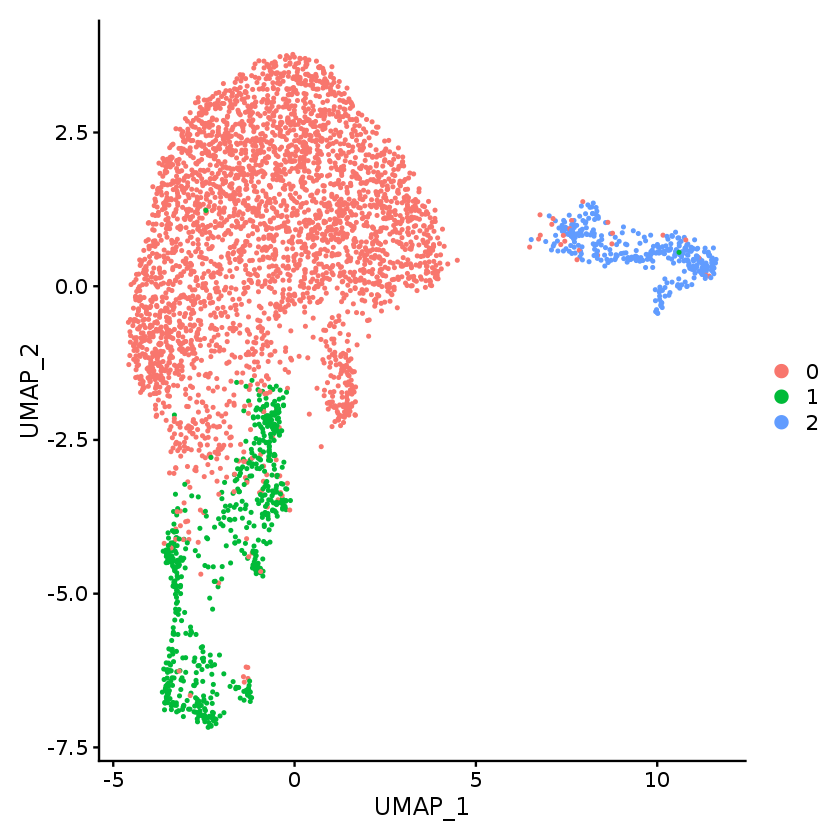

In [72]:
cd8 <- subset(rcc.integrated, idents = c("CD8","Cycling"))

DefaultAssay(cd8) <- "integrated"
cd8 <- FindVariableFeatures(cd8, selection.method = "vst", nfeatures = 5000)
top10 <- head(VariableFeatures(cd8), 10)
all.genes <- rownames(cd8)
cd8 <- ScaleData(cd8, features = all.genes)
cd8 <- RunPCA(cd8, features = VariableFeatures(object = cd8), npcs = 60)
cd8 <- FindNeighbors(cd8, dims = 1:30)
cd8 <- FindClusters(cd8, resolution = 0.1)
cd8 <- RunUMAP(cd8, dims = 1:30)
DimPlot(cd8)

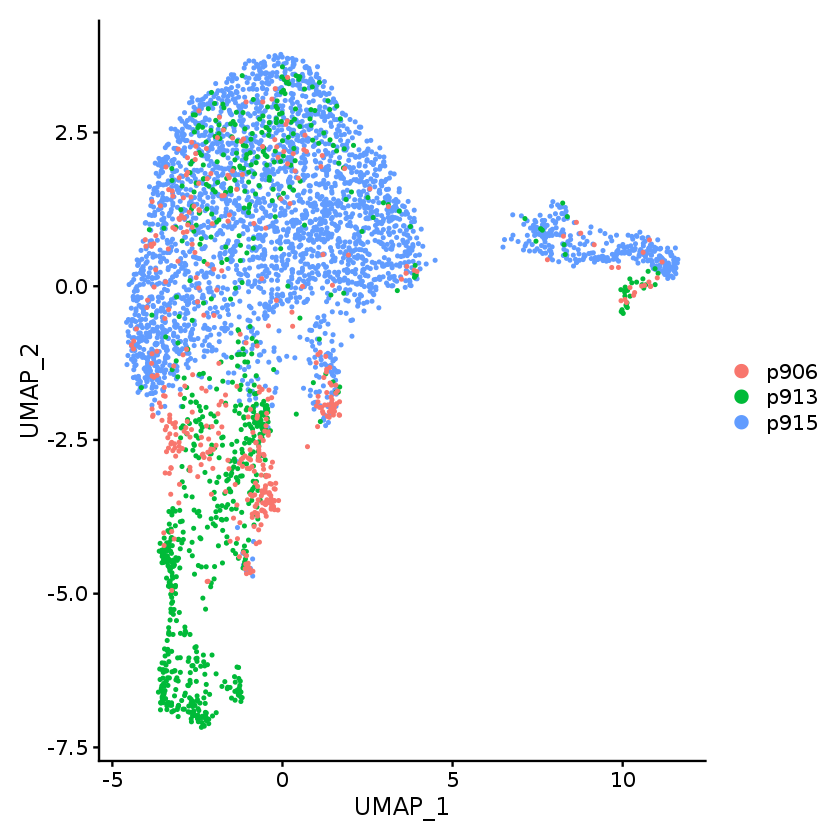

In [73]:
DimPlot(cd8, group.by = "patient")

Rerun differential expression analysis on new clusters for CD8s. 

In [74]:
cd8.markers <- FindAllMarkers(cd8, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25, assay = "RNA")
cd8.markers %>% group_by(cluster) %>% top_n(n = 5, wt = avg_logFC)

Calculating cluster 0
Calculating cluster 1
Calculating cluster 2


p_val,avg_logFC,pct.1,pct.2,p_val_adj,cluster,gene
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
1.670169e-138,0.8237568,0.906,0.614,4.177094e-134,0,RPS26
1.147400e-123,0.8775386,0.921,0.746,2.869646e-119,0,NKG7
1.614169e-103,1.1116560,0.395,0.014,4.037038e-99,0,SAA1
3.098581e-81,0.7059355,0.789,0.530,7.749551e-77,0,RARRES3
8.741136e-55,0.8631217,0.500,0.254,2.186158e-50,0,HAVCR2
0.000000e+00,2.6086750,0.604,0.034,0.000000e+00,1,IGKC
7.651541e-224,2.1264388,0.580,0.089,1.913650e-219,1,IGHA1
1.243074e-193,1.4708428,0.306,0.011,3.108928e-189,1,IGLC3
9.803535e-140,1.5816890,0.895,0.791,2.451864e-135,1,MT-ND3


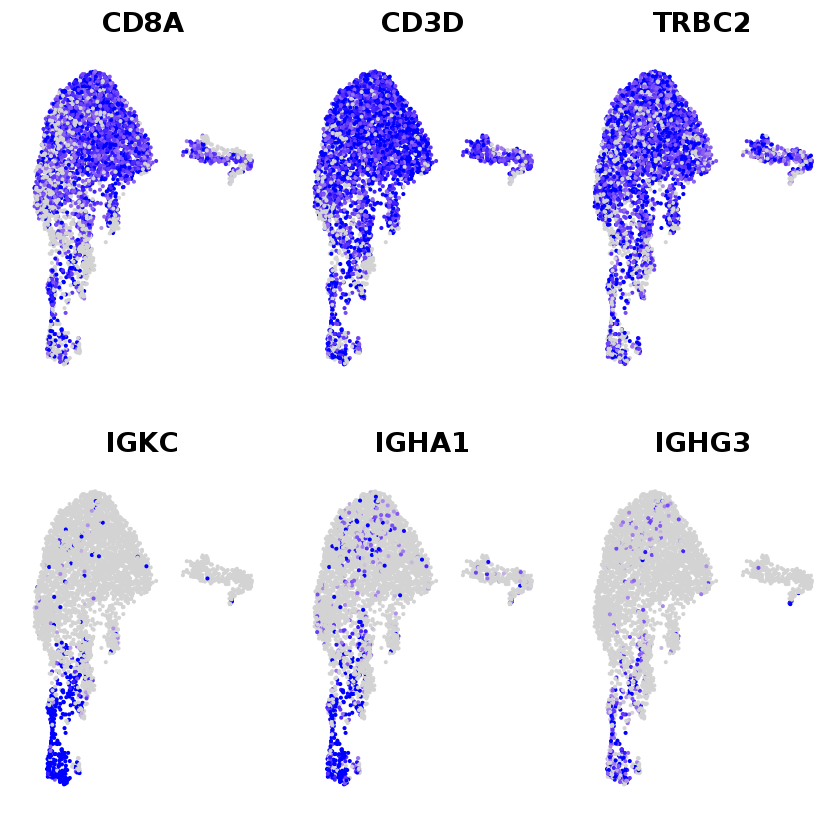

In [75]:
DefaultAssay(cd8) <- "RNA"
p <- FeaturePlot(cd8, c("CD8A","CD3D","TRBC2","IGKC","IGHA1","IGHG3"), pt.size = 0.1, min.cutoff = 0, max.cutoff = 3, combine = F, order = F)

for(i in 1:length(p)) {
  p[[i]] <- p[[i]] + NoLegend() + NoAxes()
}

cowplot::plot_grid(plotlist = p)
DefaultAssay(cd8) <- "integrated"

Here we obtain a strange result. Cluster 1, consisting primarily of cells from p913 and p906, exhibit strong differential expression of some plasma B cell genes, namely IGKC, IGHA1, and IGLC3. This could be due to a number of reasons - undetected doublets, or perhaps under or over-correction of ambient RNA profiles. Indeed, immunoglobulin genes appear frequently in low-UMI droplets, meaning that they are over-represented in ambient RNA, perhaps due to cell morphological reasons. From the feature plot aboce, we can see that many of the cells in cluster 1 express T cell and CD8 T cell markers, as well as immunoglobulin genes. These are likely CD8 T cells for which ambient RNA decontamination has not been able to sufficiently remove the ambient profile. 

For the sake of this analysis, we can subset the CD8 compartment again to remove this potentially confounding subpopulation of cells, and focus only on those CD8s which do not exhibit the abnormal expression of IG genes.

Centering and scaling data matrix
Warning message in FindVariableFeatures.Assay(object = assay.data, selection.method = selection.method, :
"selection.method set to 'vst' but count slot is empty; will use data slot instead"Warning message in eval(predvars, data, env):
"NaNs produced"Warning message in hvf.info$variance.expected[not.const] <- 10^fit$fitted:
"number of items to replace is not a multiple of replacement length"PC_ 1 
Positive:  UBE2C, BIRC5, AURKB, TOP2A, MKI67, CCNB2, STMN1, CDC20, GTSE1, CDK1 
	   CKS1B, MXD3, CDKN3, CENPF, TUBB4B, PCLAF, ZWINT, RRM2, HIST1H4C, TUBA1B 
	   CENPA, PLK1, KIF2C, CENPW, CCNA2, KIFC1, TUBB, SPC25, NUSAP1, TYMS 
Negative:  CCL5, STEAP3, AF106564.1, AL121768.2, LURAP1L, EDN2, FAM107A, SLC5A8, MYH14, PDPN 
	   AC093895.1, KAAG1, SPRY4, CABP1, FTL, NKG7, SAA1, LYVE1, RETN, DLL4 
	   CLEC5A, THSD7A, CCL4, FBLN2, SLC18A2, C4BPA, MSX1, LAMC3, NKX2-1, RND3 
PC_ 2 
Positive:  FAM107A, AL121768.2, CABP1, KAAG1, SLC5A8, AF106564.1, MYH14, EDN2, SPRY4, S

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3581
Number of edges: 147267

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.7552
Number of communities: 7
Elapsed time: 0 seconds


08:38:39 UMAP embedding parameters a = 0.9922 b = 1.112
08:38:39 Read 3581 rows and found 30 numeric columns
08:38:39 Using Annoy for neighbor search, n_neighbors = 30
08:38:39 Building Annoy index with metric = cosine, n_trees = 50
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
08:38:40 Writing NN index file to temp file /tmp/21672004.1.interactive/Rtmpr0P3mk/file7b2163fce61a
08:38:40 Searching Annoy index using 1 thread, search_k = 3000
08:38:42 Annoy recall = 100%
08:38:42 Commencing smooth kNN distance calibration using 1 thread
08:38:43 Initializing from normalized Laplacian + noise
08:38:43 Commencing optimization for 500 epochs, with 149942 positive edges
08:38:58 Optimization finished


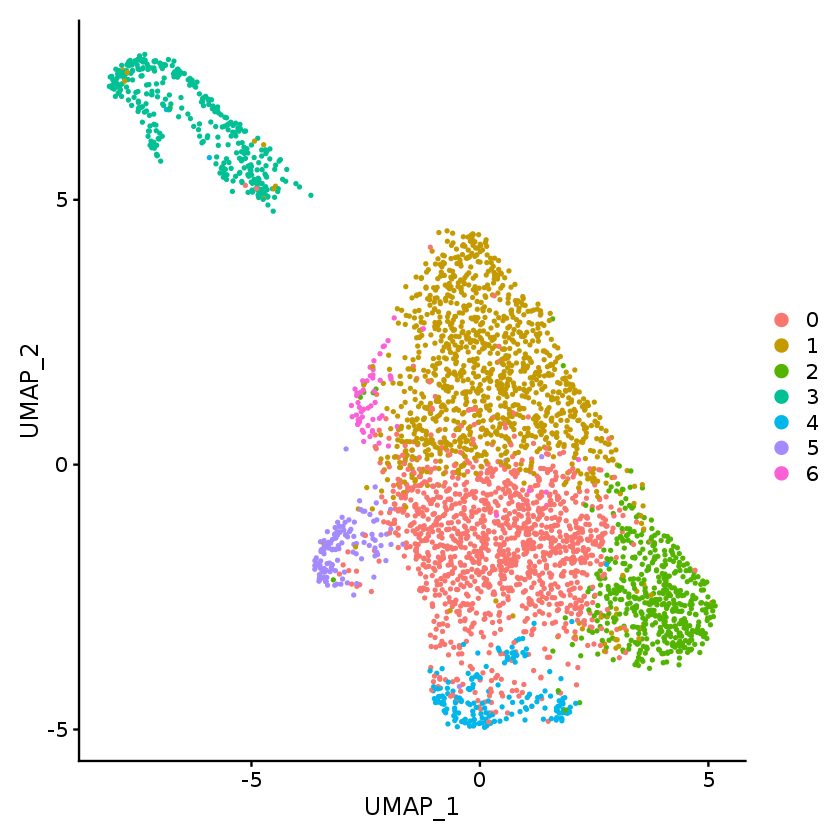

In [76]:
cd8 <- subset(cd8, idents = c(0,2))

DefaultAssay(cd8) <- "integrated"
all.genes <- rownames(cd8)
cd8 <- ScaleData(cd8, features = all.genes)
cd8 <- FindVariableFeatures(cd8, selection.method = "vst", nfeatures = 5000)
top10 <- head(VariableFeatures(cd8), 10)
cd8 <- RunPCA(cd8, features = VariableFeatures(object = cd8), npcs = 60)
cd8 <- FindNeighbors(cd8, dims = 1:30)
cd8 <- FindClusters(cd8, resolution = 0.5)
cd8 <- RunUMAP(cd8, dims = 1:30)
DimPlot(cd8)

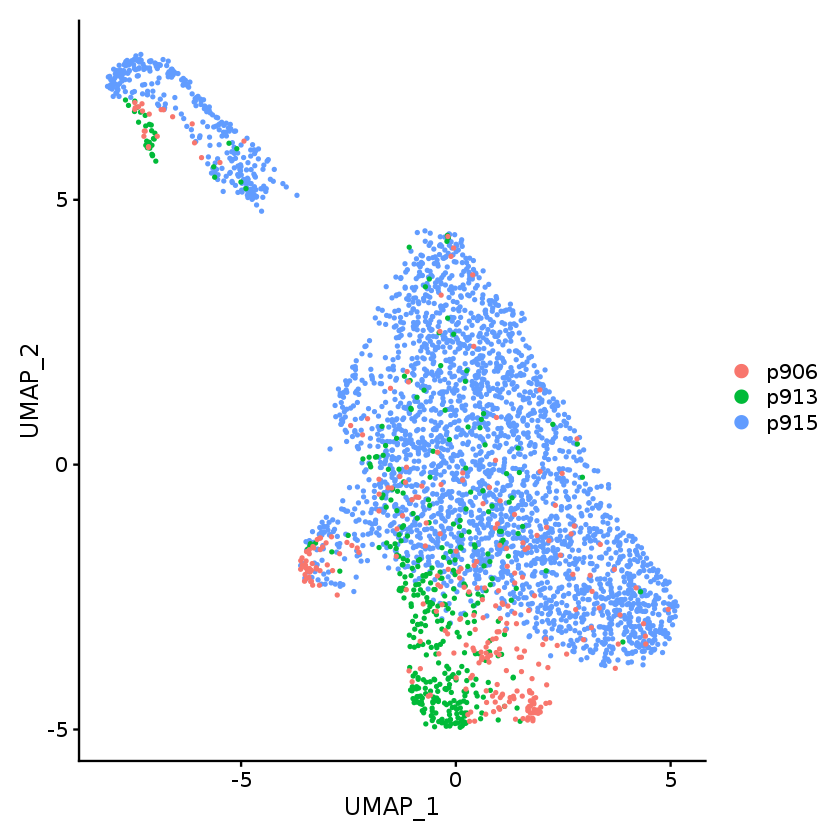

In [77]:
DimPlot(cd8, group.by = "patient")

Below, using a feature plot, we can observe some clear heterogeneity in the expression of coinhibitory receptors (PDCD1, HAVCR2, LAG3), a master regulator of exhaustion (TOX), an activation marker (TNFRSF9), and several effector molecules (IFNG, GZMB, PRF1). 

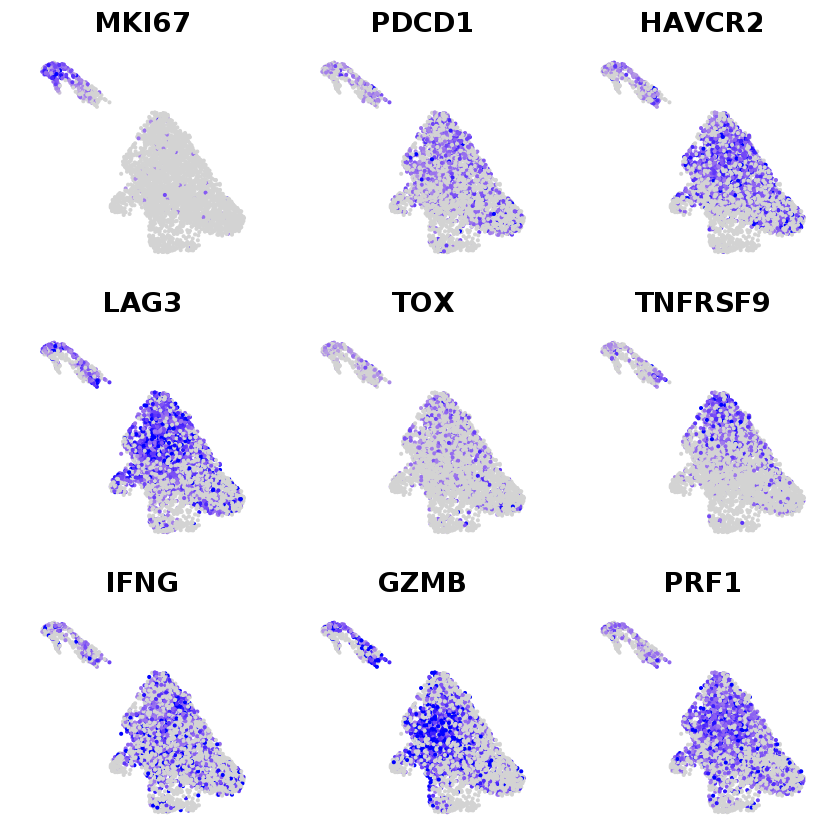

In [78]:
DefaultAssay(cd8) <- "RNA"
p <- FeaturePlot(cd8, c("MKI67","PDCD1","HAVCR2","LAG3","TOX","TNFRSF9","IFNG","GZMB","PRF1"), pt.size = 0.1, min.cutoff = 0, max.cutoff = 3, combine = F, order = F)

for(i in 1:length(p)) {
  p[[i]] <- p[[i]] + NoLegend() + NoAxes()
}

cowplot::plot_grid(plotlist = p)
DefaultAssay(cd8) <- "integrated"

## VISION signature scoring to phenotypically characterize subpopulations
The VISION R package (https://yoseflab.github.io/VISION/) implements a method for scoring individual cells with custom transcriptional signatures. Signatures can be supplied in the form of a GMT file. Here, we score our CD8 T cells with a published signature describing terminally exhausted CD8 (https://pubmed.ncbi.nlm.nih.gov/30388456/). Terminally exhausted CD8s are short-lived and exhibit elevated expression of co-inhibitory receptors, but also strongly upregulate the effector molecules GZMB, PRF1, and IFNG. In model systems of melanoma, checkpoint blockade treatment causes progenitor exhausted CD8s to differentiate into terminally exhausted CD8s, which are essential for enacting tumor killing.

First, we extract raw counts from our CD8 T cell Seurat object, supply this matrix to VISION, and calculate scores for a set of signatures contained in a GMT file. We then extract the matrix of signature scores and create a duplicate Seurat object which we can then use to visualize the signature scores in projection space.

In [79]:
counts <- cd8@assays$RNA@counts
counts <- as.matrix(counts)
n.umi <- colSums(counts)
scaled_counts <- t(t(counts) / n.umi) * median(n.umi)

vis <- Vision(scaled_counts,min_signature_genes = 0,
              signatures = c("/broad/VanAllenLab_CA/xchip/cga_home/kevinbi/RCC_GENCODE30Liftover/March2020_RCC_Raw/PaperFigures/Figure2/Stemlike_v_TerminallyExh_CD8_Signatures_SplitToo.gmt"))
vis <- VISION:::calcSignatureScores(vis)
scores <- vis@SigScores
scores <- t(scores)
vision_seurobj <- cd8
vision_seurobj@assays$RNA@data <- scores

Loading data from /broad/VanAllenLab_CA/xchip/cga_home/kevinbi/RCC_GENCODE30Liftover/March2020_RCC_Raw/PaperFigures/Figure2/Stemlike_v_TerminallyExh_CD8_Signatures_SplitToo.gmt ...

Using 15099/25010 genes detected in 0.10% of cells for signature analysis.
See the `sig_gene_threshold` input to change this behavior.

Evaluating signature scores on cells...

Evaluating signature-gene importance...



Warning message:
"Could not find Terminal_Hacohen in the default search locations, found in RNA assay instead"

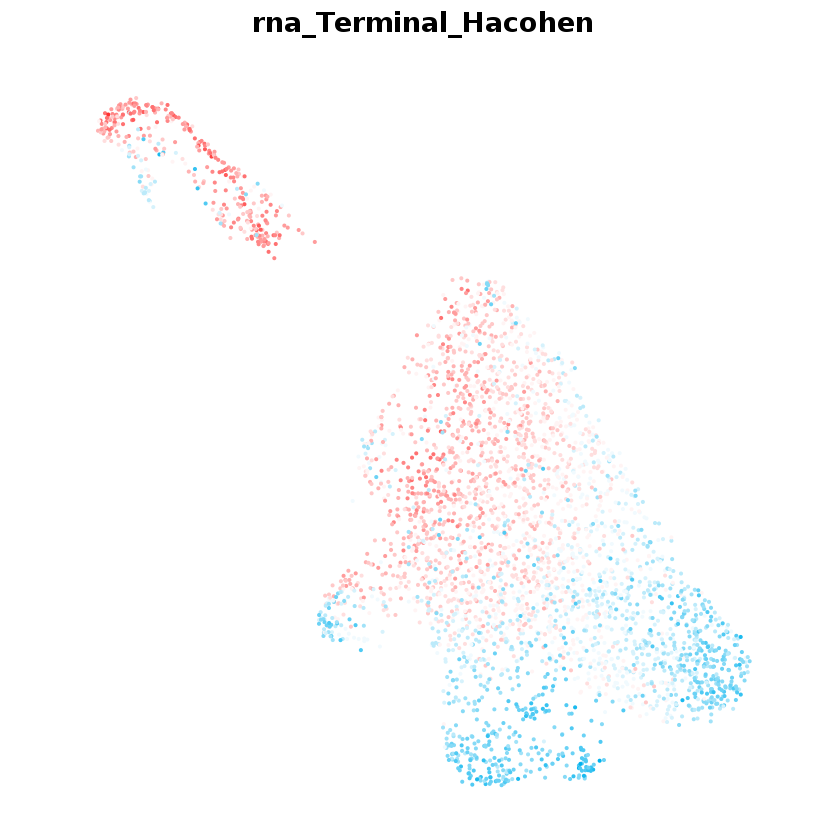

In [80]:
p <- FeaturePlot(vision_seurobj, c('Terminal_Hacohen'), cols = colorRampPalette(c("deepskyblue2", "white","firebrick1"))( 20 ), pt.size = 0.1, combine = F)
for(i in 1:length(p)) {
  p[[i]] <- p[[i]] + NoLegend() + NoAxes()
}
cowplot::plot_grid(plotlist = p)

A subset of CD8s enrich strongly for a signature of terminal exhaustion. Below, we compare signature scores between clusters, patients, biopsy sites, and treatment conditions.

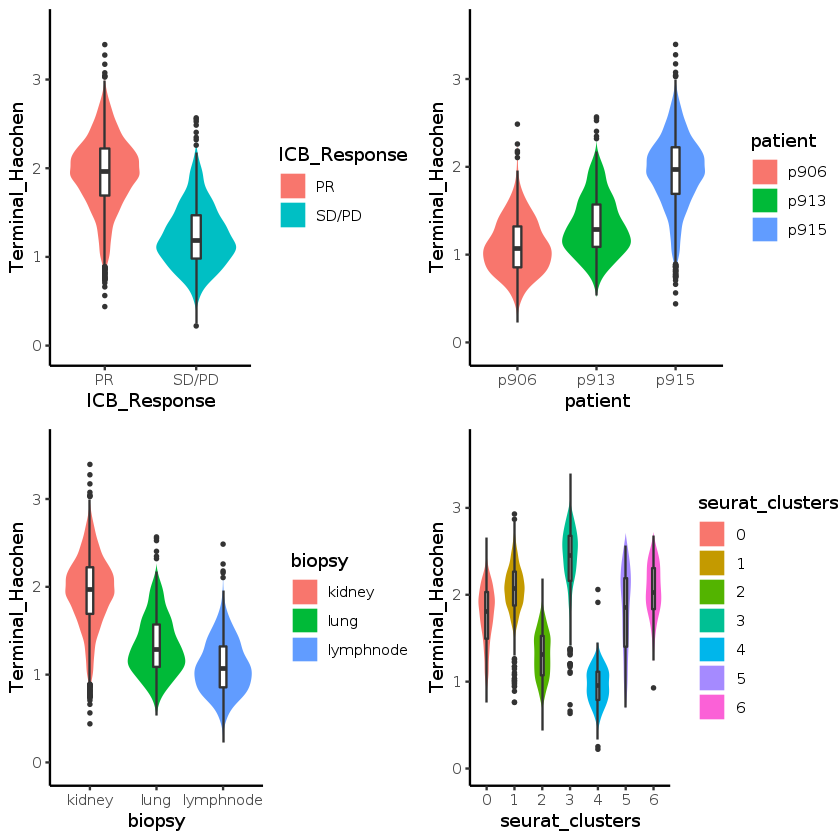

In [81]:
vision_seurobj$Terminal_Hacohen <- scores["Terminal_Hacohen",]
vision_seurobj_meta <- vision_seurobj@meta.data

icb <- ggplot(vision_seurobj_meta, aes(x=ICB_Response, y=Terminal_Hacohen, fill=ICB_Response)) + geom_violin(trim=F, color="white") + geom_boxplot(width=0.1, fill="white", outlier.size = 0.5) + theme_classic()
patient <- ggplot(vision_seurobj_meta, aes(x=patient, y=Terminal_Hacohen, fill=patient)) + geom_violin(trim=F, color="white") + geom_boxplot(width=0.1, fill="white", outlier.size = 0.5) + theme_classic()
biopsy <- ggplot(vision_seurobj_meta, aes(x=biopsy, y=Terminal_Hacohen, fill=biopsy)) + geom_violin(trim=F, color="white") + geom_boxplot(width=0.1, fill="white", outlier.size = 0.5) + theme_classic()
clust <- ggplot(vision_seurobj_meta, aes(x=seurat_clusters, y=Terminal_Hacohen, fill=seurat_clusters)) + geom_violin(trim=F, color="white") + geom_boxplot(width=0.1, fill="white", outlier.size = 0.5) + theme_classic()

ggarrange(icb, patient, biopsy, clust, nrow = 2, ncol = 2)

We can establish statistical significance for differential signature enrichment using a two-sided Wilcoxon test. Below, we show that the terminal exhaustion signature is differentially enriched in ICB PR relative to ICB SD/PD CD8s.

In [82]:
wilcox.test(subset(vision_seurobj_meta, ICB_Response == "PR")$Terminal_Hacohen,subset(vision_seurobj_meta, ICB_Response == "SD/PD")$Terminal_Hacohen)


	Wilcoxon rank sum test with continuity correction

data:  subset(vision_seurobj_meta, ICB_Response == "PR")$Terminal_Hacohen and subset(vision_seurobj_meta, ICB_Response == "SD/PD")$Terminal_Hacohen
W = 1769185, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0


## Cell type specific differential expression analysis and gene-set enrichment analysis

Returning to the full original Seurat object, we might wish to identify genes differentially expressed within a given cell type between cells from two conditions - for example, ICB PR vs ICB SD/PD. To do this, we define a new metadata field which describes both the cell type of each cell, as well as the response category of the lesion of origin.

In [83]:
rcc.integrated$celltype <- Idents(rcc.integrated)
rcc.integrated$celltype_icb <- paste(rcc.integrated$celltype, rcc.integrated$ICB_Response, sep = "_")
Idents(rcc.integrated) <- "celltype_icb"
table(Idents(rcc.integrated))


              CD8_PR               TAM_PR        GammaDelta_PR 
                2616                 1772                   77 
   Putative_Tumor_PR       Endothelial_PR          T_Helper_PR 
                 661                   62                  979 
           B_cell_PR         CLEC9A_DC_PR           Cycling_PR 
                  73                   33                  297 
      Plasma_cell_PR        Fibroblast_PR            CD8_SD/PD 
                  17                   10                 1206 
   Plasma_cell_SD/PD       T_Helper_SD/PD Putative_Tumor_SD/PD 
                 414                 1390                 1160 
        B_cell_SD/PD    Endothelial_SD/PD     GammaDelta_SD/PD 
                 738                  150                   93 
           TAM_SD/PD     Fibroblast_SD/PD        Cycling_SD/PD 
                 718                  134                   53 
     Mast_cell_SD/PD      CLEC9A_DC_SD/PD 
                  15                    5 

Below, we identify genes differentially expressed between tumor cells from ICB PR and ICB SD/PD conditions.

In [84]:
tumor_PR_vs_SDPD <- FindMarkers(rcc.integrated, ident.1 = "Putative_Tumor_PR", ident.2 = "Putative_Tumor_SD/PD", assay = "RNA", logfc.threshold = 0, min.diff.pct = 0, min.pct = 0)
subset(tumor_PR_vs_SDPD, avg_logFC > 1 & p_val_adj < 0.01)[1:20,]

,p_val,avg_logFC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
SAA1,0.000000e+00,4.750621,0.908,0.003,0.000000e+00
KRT19,4.555235e-215,2.334766,0.759,0.067,1.139264e-210
RBP5,5.286698e-205,1.736349,0.654,0.009,1.322203e-200
HLA-G,5.663813e-188,1.474155,0.595,0.002,1.416520e-183
IFI27,1.774964e-181,1.866887,0.794,0.133,4.439185e-177
UCHL1,8.636883e-179,1.694113,0.610,0.022,2.160084e-174
TMEM176B,1.671703e-176,1.875639,0.713,0.097,4.180929e-172
CXCL14,3.386640e-176,2.039897,0.607,0.022,8.469987e-172
HLA-DQA1,7.509931e-176,1.708311,0.641,0.041,1.878234e-171


We can use the avg_logFC field of this DE result as a ranking metric for GSEA. Here, we first read in a list of Hallmark, KEGG, and GO Biological Process signatures (MSigDB, https://www.gsea-msigdb.org/gsea/msigdb) from a GMT-formatted text file where each row is a signature. 

In [85]:
x <- scan("/broad/VanAllenLab_CA/xchip/cga_home/kevinbi/RCC_GENCODE30Liftover/March2020_RCC_Raw/PaperFigures/Figure5/Yue_OE_Signatures_H_KEGG_GO_Exclusion_NOGO_Edit.txt", what="", sep="\n")
# Separate elements by one or more whitepace
y <- strsplit(x, "[[:space:]]+")
# Extract the first vector element and set it as the list element name
names(y) <- sapply(y, `[[`, 1)
#names(y) <- sapply(y, function(x) x[[1]]) # same as above
# Remove the first vector element from each list element
y <- lapply(y, `[`, -1)
y <- lapply(y, `[`, -1)
y[5:10]

$HALLMARK_TNFA_SIGNALING_VIA_NFKB
  [1] "JUNB"       "CXCL2"      "ATF3"       "NFKBIA"     "TNFAIP3"   
  [6] "PTGS2"      "CXCL1"      "IER3"       "CD83"       "CCL20"     
 [11] "CXCL3"      "MAFF"       "NFKB2"      "TNFAIP2"    "HBEGF"     
 [16] "KLF6"       "BIRC3"      "PLAUR"      "ZFP36"      "ICAM1"     
 [21] "JUN"        "EGR3"       "IL1B"       "BCL2A1"     "PPP1R15A"  
 [26] "ZC3H12A"    "SOD2"       "NR4A2"      "IL1A"       "RELB"      
 [31] "TRAF1"      "BTG2"       "DUSP1"      "MAP3K8"     "ETS2"      
 [36] "F3"         "SDC4"       "EGR1"       "IL6"        "TNF"       
 [41] "KDM6B"      "NFKB1"      "LIF"        "PTX3"       "FOSL1"     
 [46] "NR4A1"      "JAG1"       "CCL4"       "GCH1"       "CCL2"      
 [51] "RCAN1"      "DUSP2"      "EHD1"       "IER2"       "REL"       
 [56] "CFLAR"      "RIPK2"      "NFKBIE"     "NR4A3"      "PHLDA1"    
 [61] "IER5"       "TNFSF9"     "GEM"        "GADD45A"    "CXCL10"    
 [66] "PLK2"       "BHLHE40"    "EGR2"       "SOCS3"      "SLC2A6"    
 [71] "PTGER4"     "DUSP5"      "SERPINB2"   "NFIL3"      "SERPINE1"  
 [76] "TRIB1"      "TIPARP"     "RELA"       "BIRC2"      "CXCL6"     
 [81] "LITAF"      "TNFAIP6"    "CD44"       "INHBA"      "PLAU"      
 [86] "MYC"        "TNFRSF9"    "SGK1"       "TNIP1"      "NAMPT"     
 [91] "FOSL2"      "PNRC1"      "ID2"        "CD69"       "IL7R"      
 [96] "EFNA1"      "PHLDA2"     "PFKFB3"     "CCL5"       "YRDC"      
[101] "IFNGR2"     "SQSTM1"     "BTG3"       "GADD45B"    "KYNU"      
[106] "G0S2"       "BTG1"       "MCL1"       "VEGFA"      "MAP2K3"    
[111] "CDKN1A"     "CCN1"       "TANK"       "IFIT2"      "IL18"      
[116] "TUBB2A"     "IRF1"       "FOS"        "OLR1"       "RHOB"      
[121] "AREG"       "NINJ1"      "ZBTB10"     "PLPP3"      "KLF4"      
[126] "CXCL11"     "SAT1"       "CSF1"       "GPR183"     "PMEPA1"    
[131] "PTPRE"      "TLR2"       "ACKR3"      "KLF10"      "MARCKS"    
[136] "LAMB3"      "CEBPB"      "TRIP10"     "F2RL1"      "KLF9"      
[141] "LDLR"       "TGIF1"      "RNF19B"     "DRAM1"      "B4GALT1"   
[146] "DNAJB4"     "CSF2"       "PDE4B"      "SNN"        "PLEK"      
[151] "STAT5A"     "DENND5A"    "CCND1"      "DDX58"      "SPHK1"     
[156] "CD80"       "TNFAIP8"    "CCNL1"      "FUT4"       "CCRL2"     
[161] "SPSB1"      "TSC22D1"    "B4GALT5"    "SIK1"       "CLCF1"     
[166] "NFE2L2"     "FOSB"       "AC129492.1" "NFAT5"      "ATP2B1"    
[171] "IL12B"      "IL6ST"      "SLC16A6"    "ABCA1"      "HES1"      
[176] "BCL6"       "IRS2"       "SLC2A3"     "CEBPD"      "IL23A"     
[181] "SMAD3"      "TAP1"       "MSC"        "IFIH1"      "IL15RA"    
[186] "TNIP2"      "BCL3"       "PANX1"      "FJX1"       "EDN1"      
[191] "EIF1"       "BMP2"       "DUSP4"      "PDLIM5"     "ICOSLG"    
[196] "GFPT2"      "KLF2"       "TNC"        "SERPINB8"   "MXD1"      

$HALLMARK_HYPOXIA
  [1] "PGK1"     "PDK1"     "GBE1"     "PFKL"     "ALDOA"    "ENO2"    
  [7] "PGM1"     "NDRG1"    "HK2"      "ALDOC"    "GPI"      "MXI1"    
 [13] "SLC2A1"   "P4HA1"    "ADM"      "P4HA2"    "ENO1"     "PFKP"    
 [19] "AK4"      "FAM162A"  "PFKFB3"   "VEGFA"    "BNIP3L"   "TPI1"    
 [25] "ERO1A"    "KDM3A"    "CCNG2"    "LDHA"     "GYS1"     "GAPDH"   
 [31] "BHLHE40"  "ANGPTL4"  "JUN"      "SERPINE1" "LOX"      "GCK"     
 [37] "PPFIA4"   "MAFF"     "DDIT4"    "SLC2A3"   "IGFBP3"   "NFIL3"   
 [43] "FOS"      "RBPJ"     "HK1"      "CITED2"   "ISG20"    "GALK1"   
 [49] "WSB1"     "PYGM"     "STC1"     "ZNF292"   "BTG1"     "PLIN2"   
 [55] "CSRP2"    "VLDLR"    "JMJD6"    "EXT1"     "F3"       "PDK3"    
 [61] "ANKZF1"   "UGP2"     "ALDOB"    "STC2"     "ERRFI1"   "ENO3"    
 [67] "PNRC1"    "HMOX1"    "PGF"      "GAPDHS"   "CHST2"    "TMEM45A" 
 [73] "BCAN"     "ATF3"     "CAV1"     "AMPD3"    "GPC3"     "NDST1"   
 [79] "IRS2"     "SAP30"    "GAA"      "SDC4"     "STBD1"    "IER3"    
 [85] "PKLR"     "IGFBP1"   "PLAUR"    "CAVIN3"   "CCN5"     "LARGE1"  
 [91] "NOCT"     "S100A4"  

Set random seed for fGSEA, extract avg_logFC and gene names to create gene rank table, then run fgsea on rank table in the scope of all signatures.

In [86]:
set.seed(200)
tum_response_rnk <- tumor_PR_vs_SDPD$avg_logFC
names(tum_response_rnk) <- row.names(tumor_PR_vs_SDPD)
corner(tum_response_rnk)

fgseaRes_response_tum <- fgsea(y, tum_response_rnk, minSize=0, maxSize= 200, nperm=1000)

SAA1    KRT19     RBP5    HLA-G    IFI27 
4.750621 2.334766 1.736349 1.474155 1.866887

Warning message in fgsea(y, tum_response_rnk, minSize = 0, maxSize = 200, nperm = 1000):
"There are ties in the preranked stats (4.33% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results."

We can now look explicitly for some signatures of interest and the leading edge genes driving their enrichment.

In [87]:
subset(fgseaRes_response_tum, pathway %in% c("HALLMARK_INTERFERON_GAMMA_RESPONSE","GO_ANTIGEN_PROCESSING_AND_PRESENTATION_OF_PEPTIDE_ANTIGEN_VIA_MHC_CLASS_I"))

pathway,pval,padj,ES,NES,nMoreExtreme,size,leadingEdge
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<list>
HALLMARK_INTERFERON_GAMMA_RESPONSE,0.002604167,0.08419471,0.7982485,2.337256,0,198,"CXCL10 , IFI27 , CD74 , C1S , HLA-DQA1, HLA-DRB1, BST2 , HLA-B , HLA-G , HLA-A , PSMB9 , SOD2 , CCL5 , TAP1 , LY6E , B2M , LAP3 , CXCL9 , VCAM1 , STAT1 , IDO1 , UBE2L6 , PARP14 , TNFSF10 , IRF1 , C1R , PSMB8 , IFIT3 , PSME1 , PSME2 , CXCL11 , MT2A , VAMP8 , PSMB2 , CD40 , IFITM3 , CASP4 , PLSCR1 , HLA-DMA , ISG15 , EPSTI1 , CASP8 , GBP4 , ISG20 , SERPING1, PFKP , ICAM1 , IFI35 , TAPBP , WARS , PSMA2 , VAMP5 , IRF9 , XAF1 , NFKBIA , SOCS1 , GZMA , OGFR , IFI44 , PSMA3 , APOL6 , SAMD9L , FAS , RBCK1 , NMI , HELZ2 , IFNAR2 , MX1 , CASP1 , RTP4 , SLC25A28, TNFAIP2 , NLRC5 , IRF7 , IFIT2 , IL15RA , TRAFD1 , IFIT1 , TNFAIP3 , CDKN1A"
GO_ANTIGEN_PROCESSING_AND_PRESENTATION_OF_PEPTIDE_ANTIGEN_VIA_MHC_CLASS_I,0.002341920,0.08419471,0.8203688,2.157146,0,87,"HLA-B , HLA-G , HLA-A , PSMB9 , TAP1 , HLA-C , B2M , HLA-F , PSMA7 , CALR , PDIA3 , PSMA4 , PSMB8 , PSME1 , HLA-E , PSME2 , PSMB2 , PSMA5 , PSMA1 , PSMD14, CYBA , PSMC4 , TAPBP , PSMA2 , PSMB1 , PSMD13, PSMC3 , PSMB4 , BCAP31, TAP2 , PSMD8 , PSMD2 , PSMC2 , PSMA3 , PSMD4 , ERAP2"


We can also visualize the expression of these leading edge genes in a heatmap of expression averaged within tumor cells of each patient in the cohort.

Centering and scaling data matrix
Finished averaging RNA for cluster p915
Finished averaging RNA for cluster p906
Finished averaging RNA for cluster p913
Finished averaging integrated for cluster p915
Finished averaging integrated for cluster p906
Finished averaging integrated for cluster p913
Centering and scaling data matrix


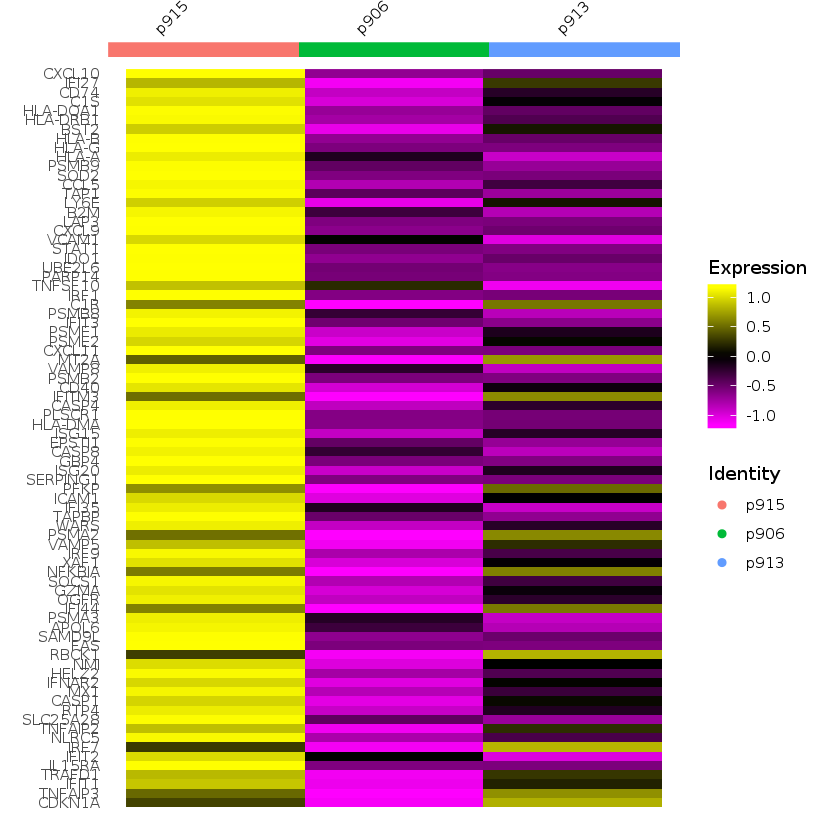

In [88]:
Idents(rcc.integrated) <- "celltype"
rcc.integrated_foravg <- subset(rcc.integrated, idents = "Putative_Tumor")

Idents(rcc.integrated_foravg) <- factor(rcc.integrated_foravg$patient, levels = c("p915","p906","p913"))

DefaultAssay(rcc.integrated_foravg) <- "RNA"
all.genes <- row.names(rcc.integrated_foravg)
rcc.integrated_foravg <- ScaleData(rcc.integrated_foravg, features = all.genes)

cluster.averages <- AverageExpression(rcc.integrated_foravg, return.seurat = TRUE)

DoHeatmap(cluster.averages, features = fgseaRes_response_tum$leadingEdge[[which(fgseaRes_response_tum$pathway == "HALLMARK_INTERFERON_GAMMA_RESPONSE")]], size = 3, 
    draw.lines = FALSE)

We can also plot these results as traditional GSEA curves. First, we define a custom plotEnrichment function with improved aesthetics and customizable y-axis breaks and limits.

In [89]:
plotEnrichment <- function (pathway, stats, gseaParam = 1, ticksSize = 0.1, ybreaks, ylims, curvecol) 
{
    rnk <- rank(-stats)
    ord <- order(rnk)
    statsAdj <- stats[ord]
    statsAdj <- sign(statsAdj) * (abs(statsAdj)^gseaParam)
    statsAdj <- statsAdj/max(abs(statsAdj))
    pathway <- unname(as.vector(na.omit(match(pathway, names(statsAdj)))))
    pathway <- sort(pathway)
    gseaRes <- calcGseaStat(statsAdj, selectedStats = pathway, 
        returnAllExtremes = TRUE)
    bottoms <- gseaRes$bottoms
    tops <- gseaRes$tops
    n <- length(statsAdj)
    xs <- as.vector(rbind(pathway - 1, pathway))
    ys <- as.vector(rbind(bottoms, tops))
    toPlot <- data.frame(x = c(0, xs, n + 1), y = c(0, ys, 0))
    diff <- (max(tops) - min(bottoms))/8
    x = y = NULL
    g <- ggplot(toPlot, aes(x = x, y = y)) + geom_point(color = curvecol, 
        size = 0.4) + geom_hline(yintercept = 0, 
        colour = "black") + geom_line(color = curvecol, size = 0.25, linetype = "dashed") + theme_bw() + 
        geom_segment(data = data.frame(x = pathway), mapping = aes(x = x, 
            y = -diff/2, xend = x, yend = diff/2), size = ticksSize, color = curvecol) + 
        theme_classic() + 
        labs(x = "rank", y = "enrichment score") + scale_y_continuous(breaks=ybreaks, limits = ylims)
    g
}

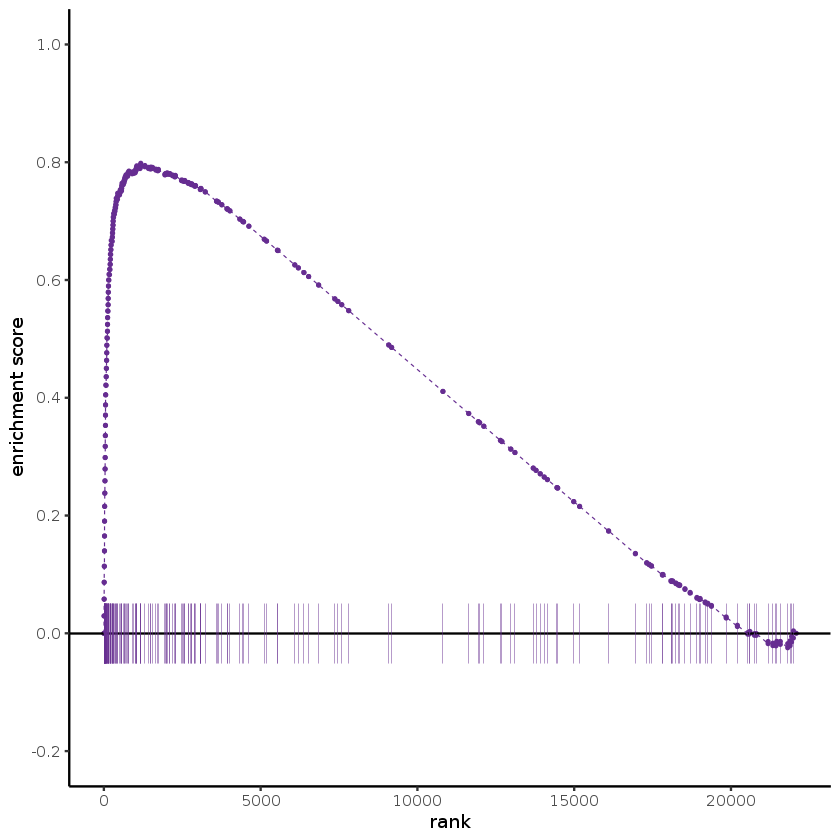

In [90]:
plotEnrichment(y[["HALLMARK_INTERFERON_GAMMA_RESPONSE"]], tum_response_rnk, ybreaks = c(-0.2,0,0.2,0.4,0.6,0.8,1), ylims = c(-0.2,1), curvecol = "#662d91")